# Spiral classification

In [1]:
import torch
from torch import nn, optim
from math import pi as π

In [2]:
from res.plot_lib import plot_data, plot_model, set_default, acc, overwrite, plot_2d_energy_levels, plot_3d_energy_levels

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using:", device)

device = "cpu"

Using: cuda:0


## Create the data

In [5]:
seed = 12345
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
n = 2     # input dimensions
K = 5     # num_classes
d = 100   # num_hidden_units

In [6]:
# Generate spirals

t = torch.linspace(0, 1, N)
a = 0.8 * t + 0.2  # amplitude 0.2 → 1.0
X = list()
y = list()
for k in range(K):
    θ = (2 * t + k) * 2 * π / K + 0.2 * torch.randn(N)
    X.append(torch.stack((a * θ.sin(), a * θ.cos()), dim=1))
    y.append(torch.zeros(N, dtype=torch.long).fill_(k))
X = torch.cat(X)
y = torch.cat(y)

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (5000, 2)
y: (5000,)


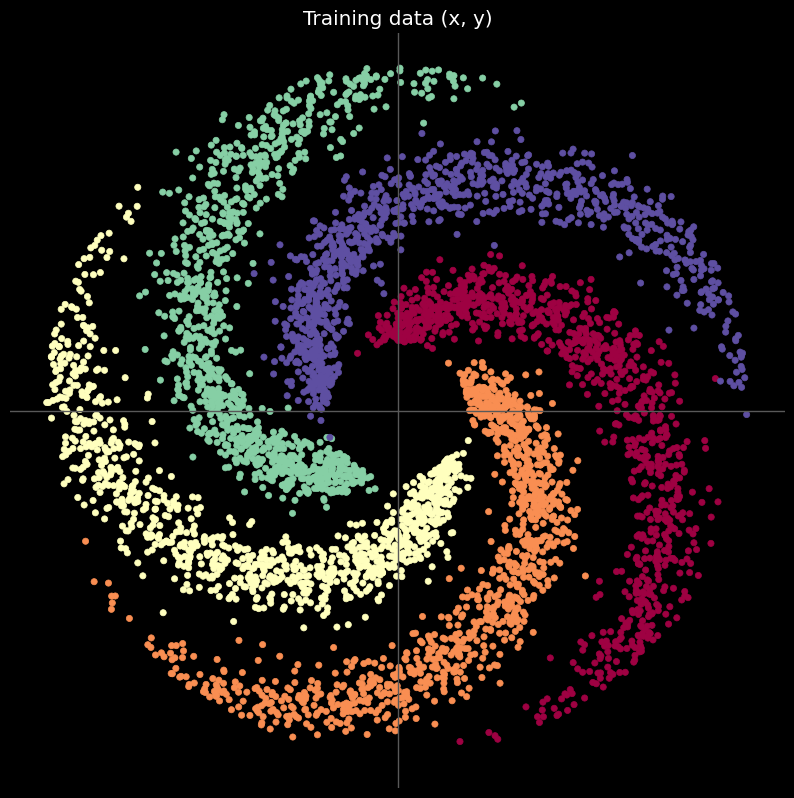

In [7]:
# And visualise them
plot_data(X, y)

## Build and train a neural net

In [8]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [55]:
# Model definition
model = nn.Sequential(
    nn.Linear(n, d),
    nn.ReLU(),  # Comment this line for a linear model
    nn.Linear(d, K)
)
model.to(device)  # possibly send to CUDA

# Cross entropy given the output logits
C = torch.nn.CrossEntropyLoss(reduction='none')

# Using Adam optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Full-batch training loop
for t in range(1_000):
    
    # Feed forward to get the logits
    l = model(X)
    
    # Compute the free energy F
    F = C(l, y)
    L = F.mean()
    
    # Zero the gradients
    optimiser.zero_grad()
    
    # Backward pass to compute and accumulate the gradient
    # of the free energy w.r.t our learnable params
    L.backward()
    
    # Update params
    optimiser.step()
    
    # Display epoch, L, and accuracy
    overwrite(f'[EPOCH]: {t}, [LOSS]: {L.item():.6f}, [ACCURACY]: {acc(l, y):.5f}')

[EPOCH]: 999, [LOSS]: 0.224297, [ACCURACY]: 0.96140


In [56]:
# Plot trained model
print(model)
plot_model(X, y, model)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=5, bias=True)
)


In [57]:
# Compute logits for a fine grid over the input space

mesh = torch.arange(-1.5, 1.5, 0.01)
xx, yy = torch.meshgrid(mesh, mesh)
grid = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)
with torch.no_grad():
    logits = model(grid)

In [58]:
# Choice of free energy

fe = 'cross-entropy'
# fe = 'negative logit'

In [59]:
# Switch to non-interactive matplotlib
%matplotlib inline
set_default()

In [60]:
# ! mkdir {m}-levels

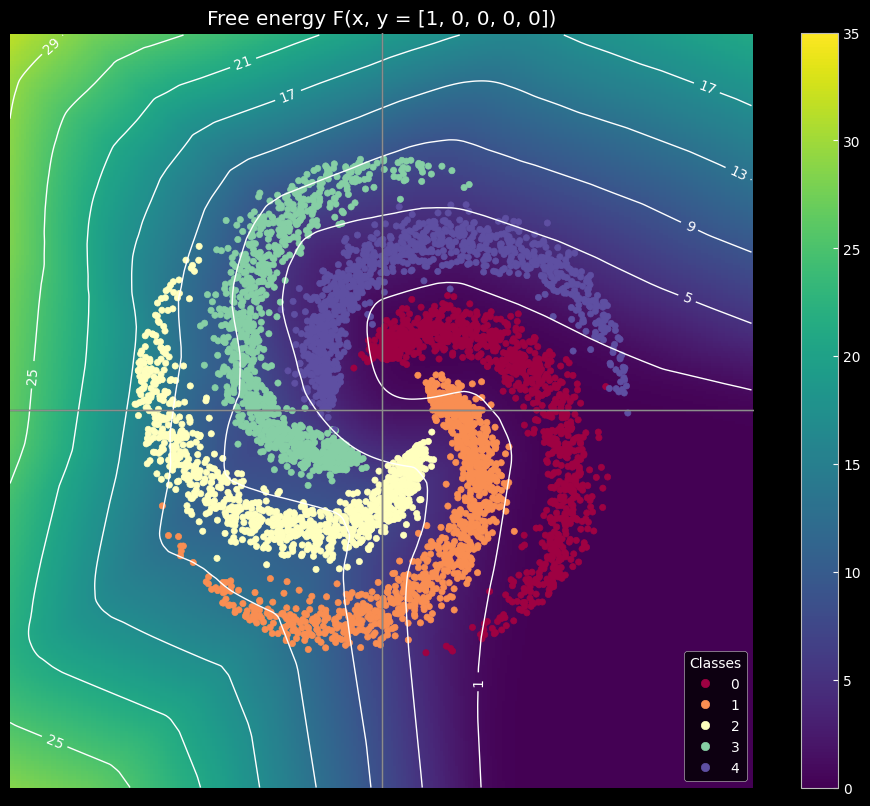

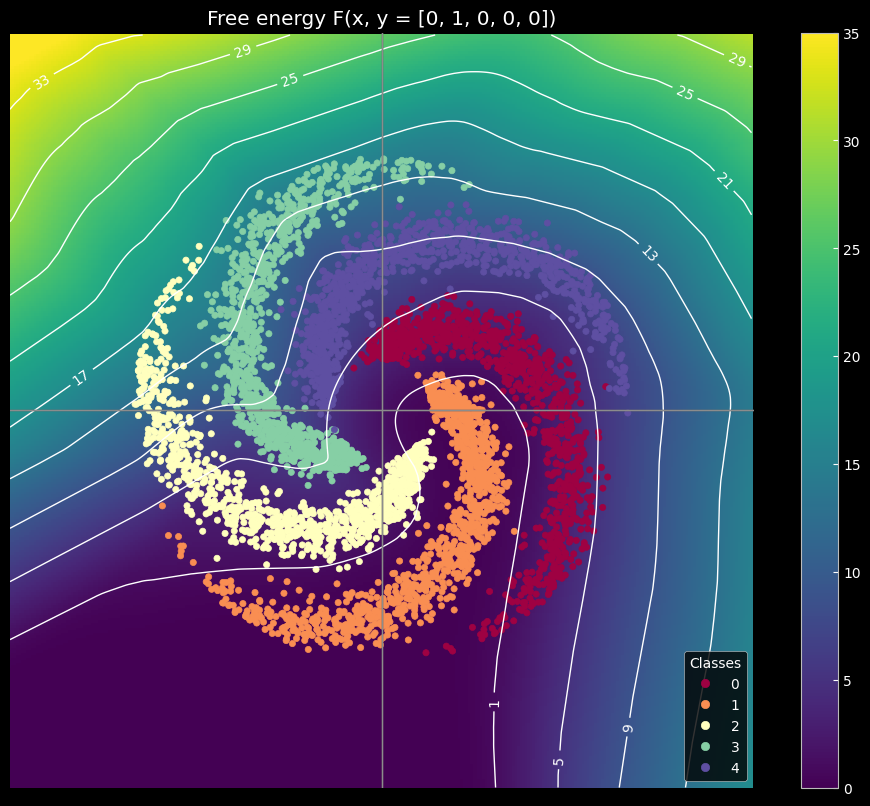

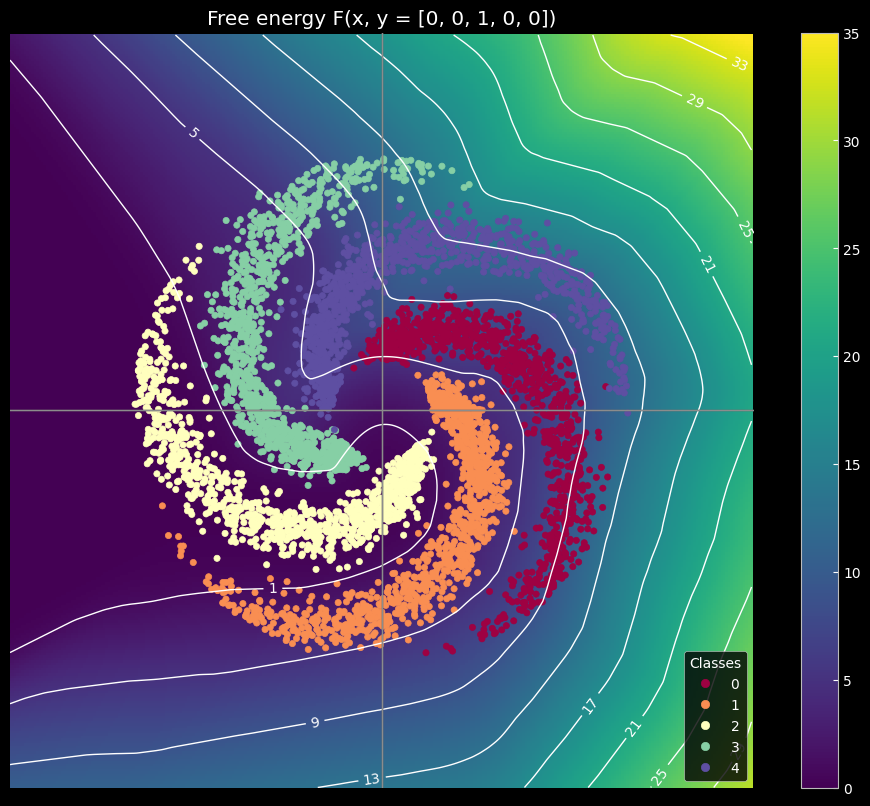

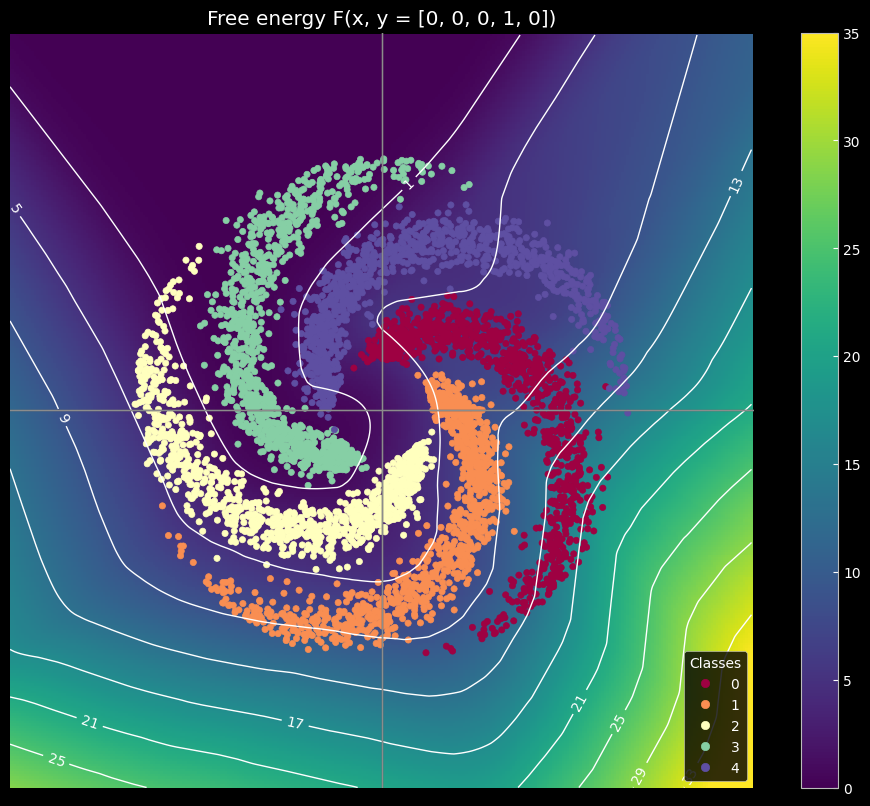

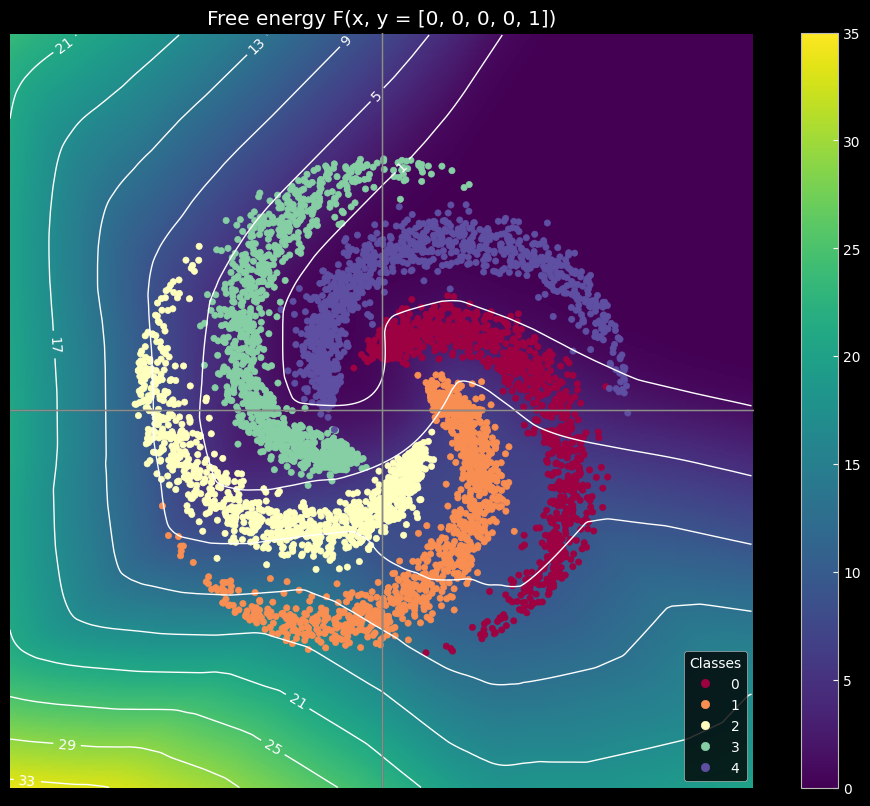

In [61]:
# Plot 2d energy levels

for k in range(K):
    if fe == 'cross-entropy':
        F = C(logits, torch.LongTensor(1).fill_(k).expand(logits.size(0)))
        F = F.reshape(xx.shape)
        plot_2d_energy_levels(X, y, (xx, yy, F, k, K), (0, 35), (1, 35, 4))

    elif fe == 'negative logit':
        F = -logits[:, k]
        F = F.reshape(xx.shape)
        plot_2d_energy_levels(X, y, (xx, yy, F, k, K), (-20, 20), (-20, 21, 2.5))
        
#     plt.savefig(f'{m}-levels/{k}.png', bbox_inches='tight')

In [62]:
# ! ffmpeg -framerate 1 -i {m}-levels/%d.png -r 25 -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" -pix_fmt yuv420p {m}-levels.mp4

In [63]:
# Switch to interactive matplotlib
%matplotlib notebook
set_default()

<IPython.core.display.Javascript object>


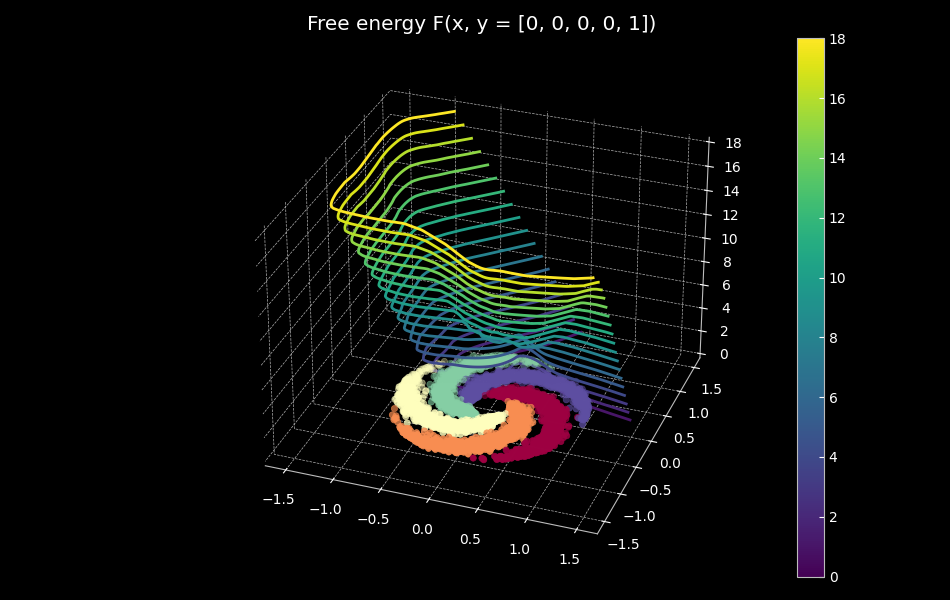

In [64]:
# Cross-entropy
if fe == 'cross-entropy':
    fig, ax = plot_3d_energy_levels(X, y, (xx, yy, F, k, K), (0, 18), (0, 19, 1), (0, 19, 2))
elif fe == 'negative logit':
    fig, ax = plot_3d_energy_levels(X, y, (xx, yy, F, k, K), (-30, 20), (-30, 20, 1), (-30, 21, 5))

In [65]:
# ! mkdir {m}-3d-levels

In [66]:
# Spin it around (and maybe save to disk)
δ = 10
for angle in range(0, 360, δ):
    ax.view_init(30, -60 + angle)
    fig.canvas.draw()
#    plt.pause(.001)
#     plt.savefig(f'{m}-3d-levels/{angle:03d}.png', bbox_inches='tight')

In [67]:
# ! ffmpeg -i {m}-3d-levels/%03d.png -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" -pix_fmt yuv420p {m}-3d-levels.mp4